# WholeSlideImageSampler demo

This respository aims to develop a tool for sampling from Whole-Slide-Images (WSIs) in an efficient manner. By sampling we mean producing batches of patches which can then be fed to e.g. machine learning algorithms. This should ideally be achieved without storing all the patches on disk (waste of storage). It aims to work with all WSIs that can be read by [openslide](https://github.com/openslide/openslide-python). We also have an implementation of JP2Plus, that would allow to use all the same functionality with jp2 image format. However, user must have matlab engine installed. Sample data is available [here](https://www.dropbox.com/s/4xcbfefhcfyi914/test_data.zip?dl=0).

## Assumptions

- You have WSIs in a format readable by openslide.
- Or you have matlab engine installed
- You may also have multi-resolution-image annotation files, such as those exportable by the slide annotation tool [ASAP](https://github.com/computationalpathologygroup/ASAP) (which supports all openslide readable images). For example, see the folder 'annotation' in the sample data. The annotations can be multi-class.

In [1]:
from wsisampler.slides.assign import assign_wsi_plus
from wsisampler.annotation import Annotation
from wsisampler.tissuemask import TissueMask
from wsisampler.utils.frame_utils import save_patchframe_patches
from wsisampler.matlab_files.engine import get_matlab_engine

from wsisampler.sampler import Sampler

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

cur_dir = os.getcwd() # Get current directory

In [2]:
def show_PIL(pil_im, size=5):
    '''A function to show PIL images in the notebook.'''
    plt.figure(figsize=(size,size))
    plt.imshow(np.asarray(pil_im),cmap='gray')

# Openslide based formats

### Load sample data

In [3]:
path = os.path.join(os.getcwd(), 'test_data/')
file = os.path.join(path, 'openslide_example.svs')

tissue_mask_dir = os.path.join(path, 'tissue_masks')
annotation_dir = os.path.join(path, 'annotations')
xml_dir = os.path.join(path, 'xml')
patches_dir = os.path.join(path, 'patches')

### View the slide

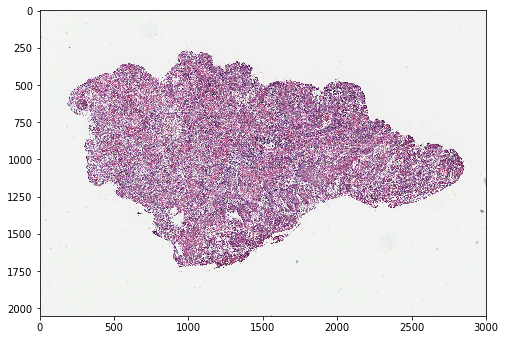

In [4]:
slide = assign_wsi_plus(file, level0=40)
thumb = slide.get_thumbnail(size=(3000,3000))
show_PIL(thumb, size=8)

### View the generated tissue mask

Tissue mask found. Loading.


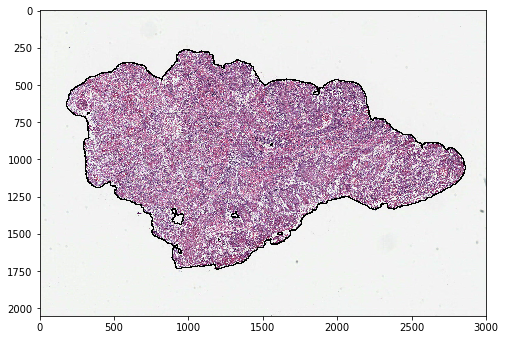

In [5]:
tissue_mask = TissueMask(tissue_mask_dir, reference_wsi=slide)
vis = tissue_mask.visualize(reference_wsi=slide)
show_PIL(vis, size=8)

### Generate annotation

Here we will generate a mask and visualise annotations produced using ASAP. For that we need to define an `xml_reader` object, that will handle ASAP xml format. Subsequently, `xml_reader` and the reference slide need to be passed to `Annotation` object.

`xml_reader` objects for Virtual Slide Maker and for ASAP inherit from an abstract class. This allows to implement custom xml readers for custom purposes or other annotation tools.

In [6]:
# Initialise xml reader object for ASAP xml
from wsisampler.xml.xml import XMLAsap
xml_reader = XMLAsap()

Ready annotation mask is not found
Annotation mask has been made, saved, and loaded


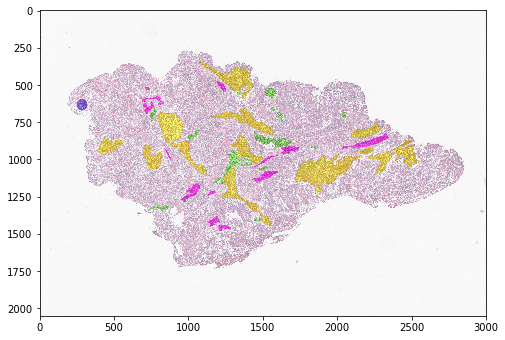

In [8]:
annotation = Annotation(search_dir=annotation_dir, 
                      reference_wsi=slide,
                      xml_dir=xml_dir,
                      xml_reader=xml_reader)
vis = annotation.visualize(reference_wsi=slide)
show_PIL(vis, size=8)

### Sample patches

To sample patches we instantiate `Sampler` object. Into the object we pass the path to the whole slide image, the maginification at level 0, and the corresponding directories for tissue mask and annotation. Additionally, we have to pass an xml reader and the directory where xml files are.

In [9]:
sampler = Sampler(file, level0=40, 
                  tissue_mask_dir=tissue_mask_dir, 
                  annotation_dir=annotation_dir,
                  xml_dir=xml_dir,
                  engine=None, 
                  xml_reader=xml_reader)

Tissue mask found. Loading.
Annotation mask found. Loading.
Annotation found, initialising


The line below will scan the whole slide image, and identify all candidate coordinates for each class and non-annotated regions.

In [10]:
sampler.prepare_sampling(magnification=40, patchsize=256)

The function below will generate pandas data-frame that would store all the necessary information for each patch. We may specify if want to include the un-annotated class using `ignore_bg` parameter; specify the maximum number per each class using `max_per_class` where we can either put an integer or string `ALL`, where in the latter casses all patches will be extracted.

`save_patchframe_patches` function will save all the patches into a specified directory given the generated patch-frame.

In [11]:
patchframe = sampler.sample_patches(ignore_bg=True, max_per_class=20, savedir=path)

Rejected 35 patches for file openslide_example
Saving patchframe to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/test_data/openslide_example_patchframe.pickle


In [31]:
save_patchframe_patches(patchframe, patches_dir) # look in this directory

Saving hard copies of patches in patchframe to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/test_data/patches.


# JP2 format (requires matlab engine!)

### Load sample data

Matlab engine has to receive full path unfortunately. Hence the code below.

In [12]:
file = os.path.join(path, 'jp_example.jp2')

We provide a convinience function `get_matlab_engine`, that will return matlab engine provided that you have one setup.

In [13]:
engine = get_matlab_engine()

### View the slide

Just like with openslide formats, we can generate a thumbnail for jp2 image and view it. However, this time we have to pass matlab engine into each wsisampler object.

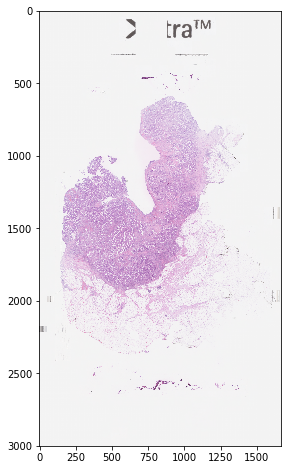

In [14]:
# Given engine it will automatically select JP2Open
slide = assign_wsi_plus(file, level0=20, engine=engine)
thumb = slide.get_thumbnail(size=(3000,3000))
show_PIL(thumb, size=8)

### Generate tissue mask

**You must pass engine with functions that call WSI object**, this is done for efficiency so that new instance of matlab engine does not have to be created every time.

Tissue mask found. Loading.


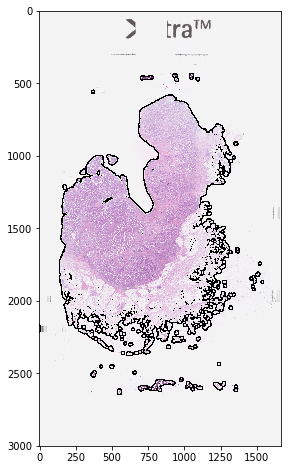

In [15]:
tissue_mask = TissueMask(tissue_mask_dir, reference_wsi=slide)
vis = tissue_mask.visualize(reference_wsi=slide)
show_PIL(vis, size=8)

### Generate annotation

In this case, annotation has been generated using Virtual Slide Maker. Therefore we import `XMLVirtualSlideMaker` object to assist with the xml file.

In [17]:
# Initialise xml reader object for VSM xml
from wsisampler.xml.xml import XMLVirtualSlideMaker
xml_reader = XMLVirtualSlideMaker()

Ready annotation mask is not found
Annotation mask has been made, saved, and loaded


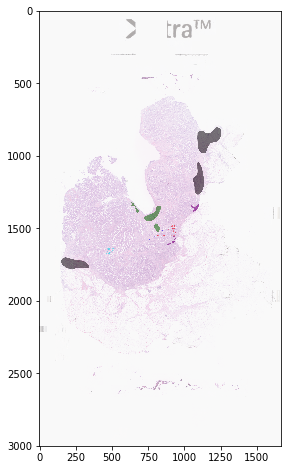

In [19]:
annotation = Annotation(search_dir=annotation_dir, 
                      reference_wsi=slide,
                      xml_dir=xml_dir,
                      xml_reader=xml_reader)
vis = annotation.visualize(reference_wsi=slide)
show_PIL(vis, size=8)

### Sample patches

To sample patches we proceed as in the example for openslide image. Except, that this time we have to pass matlab engine into the `Sampler` object, as well as into the `save_patchframe_patches` function.

In [20]:
sampler = Sampler(file, level0=40, 
                  tissue_mask_dir=tissue_mask_dir, 
                  annotation_dir=annotation_dir,
                  xml_dir=xml_dir,
                  engine=engine, 
                  xml_reader=xml_reader)

Tissue mask found. Loading.
Annotation mask found. Loading.
Annotation found, initialising


In [21]:
sampler.prepare_sampling(magnification=40, patchsize=256)

In [19]:
patchframe = sampler.sample_patches(ignore_bg=True, max_per_class=20, savedir=path)

In [18]:
save_patchframe_patches(patchframe, patches_dir, engine=engine) 